In [13]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras import layers, Model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
train_dir = "/content/drive/MyDrive/THESIS/DATASET/IMAGE/Train"
val_dir = "/content/drive/MyDrive/THESIS/DATASET/IMAGE/Val"
test_dir = "/content/drive/MyDrive/THESIS/DATASET/IMAGE/Test"

In [16]:
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode="binary",
                                                                 batch_size=32,
                                                                shuffle=False)

Found 2142 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
Found 420 files belonging to 2 classes.


In [17]:
# Visualizing data
def visualize_random_images(dataset_type="train", label_type="Others"):
    
    sample = 9
    
    plt.figure(figsize=(15, 8))
    type_dir = train_dir if dataset_type=="train" else test_dir
    base_dir = os.path.join(type_dir, label_type)
    images = random.sample(os.listdir(base_dir), 9)
    
    for i, image in enumerate(images):
        plt.subplot(3, 3, i+1)
        img = plt.imread(os.path.join(base_dir, image))
        plt.imshow(img)

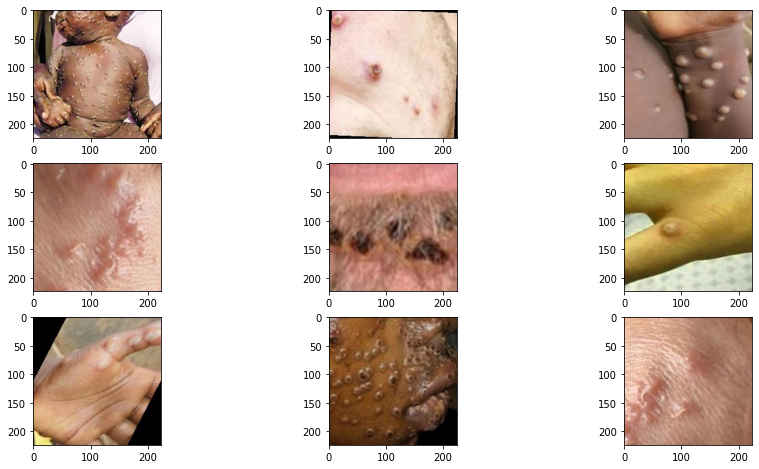

In [18]:
visualize_random_images("train", "Monkeypox")

In [19]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [20]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
base_layer = base_model(inputs)
dropout_layer_1 = layers.Dropout(0.5)(base_layer)
flat_layer = layers.Flatten()(dropout_layer_1)
dense_1 = layers.Dense(256, activation="relu")(flat_layer)
dropout_layer_2 = layers.Dropout(0.5)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(dropout_layer_2)
outputs = layers.Dense(1, activation="sigmoid")(dense_2)
model = Model(inputs, outputs)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(train_data,
                       epochs=10,
                       validation_data=val_data)

Epoch 1/10
67/67 [==============================] - 509s 7s/step - loss: 0.9288 - accuracy: 0.8413 - val_loss: 0.8289 - val_accuracy: 0.8167
Epoch 2/10
67/67 [==============================] - 477s 7s/step - loss: 0.3863 - accuracy: 0.9300 - val_loss: 1.8145 - val_accuracy: 0.7524
Epoch 3/10
67/67 [==============================] - 463s 7s/step - loss: 0.2333 - accuracy: 0.9603 - val_loss: 1.8919 - val_accuracy: 0.7738
Epoch 4/10
67/67 [==============================] - 464s 7s/step - loss: 0.2048 - accuracy: 0.9664 - val_loss: 1.6204 - val_accuracy: 0.8357
Epoch 5/10
67/67 [==============================] - 462s 7s/step - loss: 0.2503 - accuracy: 0.9613 - val_loss: 2.6766 - val_accuracy: 0.7357
Epoch 6/10
67/67 [==============================] - 464s 7s/step - loss: 0.1444 - accuracy: 0.9781 - val_loss: 1.6204 - val_accuracy: 0.7881
Epoch 7/10
67/67 [==============================] - 464s 7s/step - loss: 0.1276 - accuracy: 0.9767 - val_loss: 2.4506 - val_accuracy: 0.7905
Epoch 8/10
67

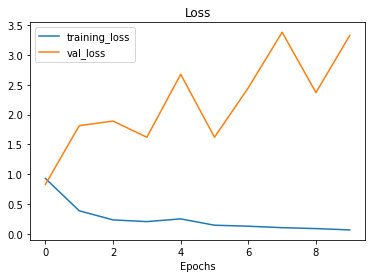

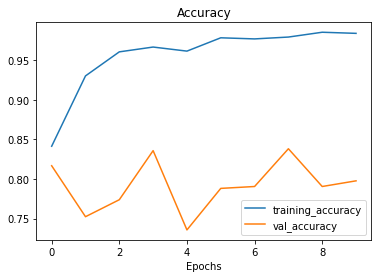

In [22]:
plot_loss_curves(history)

In [23]:
model.evaluate(test_data)

2/2 [==============================] - 14s 2s/step - loss: 1.7188 - accuracy: 0.9333


[1.71884024143219, 0.9333333373069763]

In [24]:
y_pred = tf.math.round(model.predict(test_data))
y_true = []
for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

2/2 [==============================] - 10s 2s/step


In [25]:
accuracy_score(y_true, y_pred)

0.9333333333333333

In [26]:
print(classification_report(y_true, y_pred, target_names=train_data.class_names))

              precision    recall  f1-score   support

   Monkeypox       0.87      1.00      0.93        20
      Others       1.00      0.88      0.94        25

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



<Axes: >

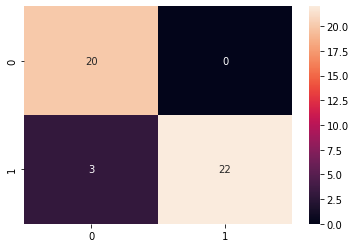

In [27]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm.astype("int"), annot=True)